## Experiments template for networks of different sizes, 1 sample from each size of network, multiple runs per sample

In [25]:
import os


dir = "networks"
os.makedirs(os.path.dirname(dir+"/"), exist_ok=True)


def make_dir(dir):
    if not os.path.exists(dir):
        os.mkdir(dir)

### Generate networks

First fixed Powerlaw networks with m = 1, and p = 0.2.\
Variable number of nodes.

In [26]:
m = 1
p = 0.2

In [27]:
dir = f"networks/powerlaw_m={m}_p={p}"
os.makedirs(os.path.dirname(dir+"/"), exist_ok=True)

In [4]:
import numpy as np


MIN_NODES = 10
MAX_NODES = 100

num_nodes = np.linspace(MIN_NODES, MAX_NODES, MAX_NODES//MIN_NODES)
num_nodes

array([ 10.,  20.,  30.,  40.,  50.,  60.,  70.,  80.,  90., 100.])

In [5]:
import numpy as np
import networkx as nx


try:
    Graphs = np.load(f"{dir}/graphs.npy", allow_pickle=True)
except:
    Graphs = np.empty(shape=(len(num_nodes),), dtype=object)
    for i, n in enumerate(num_nodes):
        Graphs[i] = nx.powerlaw_cluster_graph(n=n, m=m, p=p)
    np.save(f"{dir}/graphs.npy", Graphs)

In [6]:
# output folder
dir =dir+"/output"
os.makedirs(os.path.dirname(dir+"/"), exist_ok=True)

#### Hierarchical approach with Gurobi first

In [7]:
solver = "gurobi"
make_dir(f"{dir}/{solver}")

In [8]:
from Qommunity.samplers.hierarchical.gurobi_sampler import GurobiSampler
from Qommunity.searchers.hierarchical_community_searcher.hierarchical_community_searcher import HierarchicalCommunitySearcher

In [ ]:
from tqdm import tqdm


N_RUNS = 100


mods = np.zeros((num_nodes.shape[0], N_RUNS))
comms = np.empty((num_nodes.shape[0], N_RUNS), dtype=object)

mods_graph_N = np.zeros((N_RUNS))
comms_graph_N = np.empty((N_RUNS), dtype=object)
for i, G in tqdm(enumerate(Graphs)):
    gurobi = GurobiSampler(G, suppress_output=True)
    hierch_searcher = HierarchicalCommunitySearcher(gurobi)  
    for r in range(N_RUNS):
        comms_res = hierch_searcher.hierarchical_community_search()
        mod_score = nx.community.modularity(G, comms_res)
        mods_graph_N[r] = mod_score
        comms_graph_N[r] = comms_res

    current_net_size = int(num_nodes[i])
    mods[i] = mods_graph_N
    comms[i] = comms_graph_N
    np.save(f"{dir}/{solver}/{solver}-network_size_{current_net_size}", mods_graph_N)
    np.save(f"{dir}/{solver}/{solver}-network_size_{current_net_size}_comms", comms_graph_N)

np.save(f"{dir}/{solver}/{solver}-mods_final", mods)
np.save(f"{dir}/{solver}/{solver}-comms_final", comms)

#### Now Advantage

In [11]:
solver = "adv"
make_dir(f"{dir}/{solver}")

In [12]:
from Qommunity.samplers.hierarchical.advantage_sampler import AdvantageSampler
from Qommunity.searchers.hierarchical_community_searcher.hierarchical_community_searcher import HierarchicalCommunitySearcher

In [ ]:
from tqdm import tqdm


N_RUNS = 50


mods = np.zeros((num_nodes.shape[0], N_RUNS))
comms = np.empty((num_nodes.shape[0], N_RUNS), dtype=object)

mods_graph_N = np.zeros((N_RUNS))
comms_graph_N = np.empty((N_RUNS), dtype=object)
for i, G in tqdm(enumerate(Graphs)):
    advantage = AdvantageSampler(G, num_reads=100)
    hierch_searcher = HierarchicalCommunitySearcher(advantage)
    
    current_net_size = int(num_nodes[i])
    for r in range(N_RUNS):
        comms_res = hierch_searcher.hierarchical_community_search()
        mod_score = nx.community.modularity(G, comms_res)
        mods_graph_N[r] = mod_score
        comms_graph_N[r] = comms_res

        try:
            np.save(f"{dir}/{solver}/{solver}-network_size_{current_net_size}", mods_graph_N)
            np.save(f"{dir}/{solver}/{solver}-network_size_{current_net_size}_comms", comms_graph_N)
        except Exception as e:
            print(f"iter {i} run {r} npy saving failed:\n{e}")

    mods[i] = mods_graph_N
    comms[i] = comms_graph_N
    np.save(f"{dir}/{solver}/{solver}-network_size_{current_net_size}", mods_graph_N)
    np.save(f"{dir}/{solver}/{solver}-network_size_{current_net_size}_comms", comms_graph_N)

np.save(f"{dir}/{solver}/{solver}-mods_final", mods)
np.save(f"{dir}/{solver}/{solver}-comms_final", comms)

### Now Leiden

In [14]:
solver = "leiden"
make_dir(f"{dir}/{solver}")

In [15]:
from Qommunity.samplers.regular.leiden_sampler import LeidenSampler
from Qommunity.searchers.community_searcher.community_searcher import CommunitySearcher

In [16]:
from tqdm import tqdm


N_RUNS = 100


mods = np.zeros((num_nodes.shape[0], N_RUNS))
comms = np.empty((num_nodes.shape[0], N_RUNS), dtype=object)

mods_graph_N = np.zeros((N_RUNS))
comms_graph_N = np.empty((N_RUNS), dtype=object)
for i, G in tqdm(enumerate(Graphs)):
    leiden = LeidenSampler(G)
    searcher = CommunitySearcher(leiden)
    
    for r in range(N_RUNS):
        comms_res = searcher.community_search()
        mod_score = nx.community.modularity(G, comms_res)
        mods_graph_N[r] = mod_score
        comms_graph_N[r] = comms_res

    current_net_size = int(num_nodes[i])
    mods[i] = mods_graph_N
    comms[i] = comms_graph_N
    np.save(f"{dir}/{solver}/{solver}-network_size_{current_net_size}", mods_graph_N)
    np.save(f"{dir}/{solver}/{solver}-network_size_{current_net_size}_comms", comms_graph_N)

np.save(f"{dir}/{solver}/{solver}-mods_final", mods)
np.save(f"{dir}/{solver}/{solver}-comms_final", comms)

10it [00:00, 19.89it/s]


#### Louvain

In [17]:
solver = "louvain"
make_dir(f"{dir}/{solver}")

In [18]:
from Qommunity.samplers.regular.louvain_sampler import LouvainSampler
from Qommunity.searchers.community_searcher import CommunitySearcher

In [19]:
from tqdm import tqdm


N_RUNS = 100


mods = np.zeros((num_nodes.shape[0], N_RUNS))
comms = np.empty((num_nodes.shape[0], N_RUNS), dtype=object)

mods_graph_N = np.zeros((N_RUNS))
comms_graph_N = np.empty((N_RUNS), dtype=object)
for i, G in tqdm(enumerate(Graphs)):
    louvain = LouvainSampler(G)
    searcher = CommunitySearcher(louvain)
    
    for r in range(N_RUNS):
        comms_res = searcher.community_search()
        mod_score = nx.community.modularity(G, comms_res)
        mods_graph_N[r] = mod_score
        comms_graph_N[r] = comms_res

    current_net_size = int(num_nodes[i])
    mods[i] = mods_graph_N
    comms[i] = comms_graph_N
    np.save(f"{dir}/{solver}/{solver}-network_size_{current_net_size}", mods_graph_N)
    np.save(f"{dir}/{solver}/{solver}-network_size_{current_net_size}_comms", comms_graph_N)

np.save(f"{dir}/{solver}/{solver}-mods_final", mods)
np.save(f"{dir}/{solver}/{solver}-comms_final", comms)

10it [00:02,  4.54it/s]


### Let's plot the modularity results

In [20]:
mods_gurobi = np.load(f"{dir}/gurobi/gurobi-mods_final.npy")
mods_leiden = np.load(f"{dir}/leiden/leiden-mods_final.npy")
mods_louvain = np.load(f"{dir}/louvain/louvain-mods_final.npy")
# mods_adv = np.load(f"{dir}/adv/adv-mods_final.npy")

In [ ]:
mods_adv = np.array([np.load(f"{dir}/adv/adv-network_size_{n}.npy") for n in range(10, 90, 10)])

In [ ]:
print("\t\tMaxes\n")
print("\tadv\tlei\tgur\tlou")
digits = 8
for madv, mlei, mgur, mlou in zip(mods_adv.max(axis=-1), mods_leiden.max(axis=-1), mods_gurobi.max(axis=-1), mods_louvain.max(axis=-1)):
    madv = round(madv, digits)
    mlei = round(mlei, digits)
    mgur = round(mgur, digits)
    mlou = round(mlou, digits)
    print(madv, mlei, mgur, mlou, "\t\t", madv == mlei == mgur == mlou)
    print()


In [45]:
print("\t\tMeans\n")
print("\tadv\tlei\tgur\tlou")
digits = 8
for madv, mlei, mgur, mlou in zip(mods_adv.mean(axis=-1), mods_leiden.mean(axis=-1), mods_gurobi.mean(axis=-1), mods_louvain.mean(axis=-1)):
    madv = round(madv, digits)
    mlei = round(mlei, digits)
    mgur = round(mgur, digits)
    mlou = round(mlou, digits)
    print(madv, mlei, mgur, mlou, "\t\t", madv == mlei == mgur == mlou)
    print()


		Means

	adv	lei	gur	lou
0.38271605 0.38271605 0.38271605 0.38271605 		 True

0.55124654 0.55124654 0.55124654 0.55124654 		 True

0.58858502 0.58858502 0.58858502 0.58858502 		 True

0.67784352 0.67784352 0.67784352 0.67784352 		 True

0.65368596 0.65368596 0.65368596 0.65269471 		 False

0.69038495 0.70051709 0.69750072 0.70036627 		 False

0.76042638 0.76307498 0.76307498 0.76307498 		 False

0.66912047 0.64500881 0.64500881 0.64500881 		 False



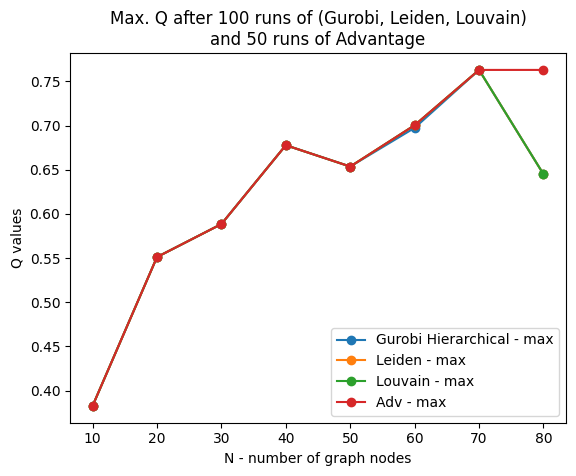

In [34]:
from matplotlib import pyplot as plt


num_nodes_up_to_80 = num_nodes[:8]


fig, ax = plt.subplots(1)
plt.plot(num_nodes_up_to_80, mods_gurobi.max(axis=-1)[:8], '-o', label="Gurobi Hierarchical - max")
plt.plot(num_nodes_up_to_80, mods_leiden.max(axis=-1)[:8], '-o', label="Leiden - max")
plt.plot(num_nodes_up_to_80, mods_louvain.max(axis=-1)[:8], '-o', label="Louvain - max")
plt.plot(num_nodes_up_to_80, mods_adv.max(axis=-1), '-o', label="Adv - max")
plt.legend()
# ax.set_title(f"Max. Q and mean Q after {N_RUNS} runs");
ax.set_title("Max. Q after 100 runs of (Gurobi, Leiden, Louvain)\nand 50 runs of Advantage");
ax.set_xlabel("N - number of graph nodes");
ax.set_ylabel("Q values");

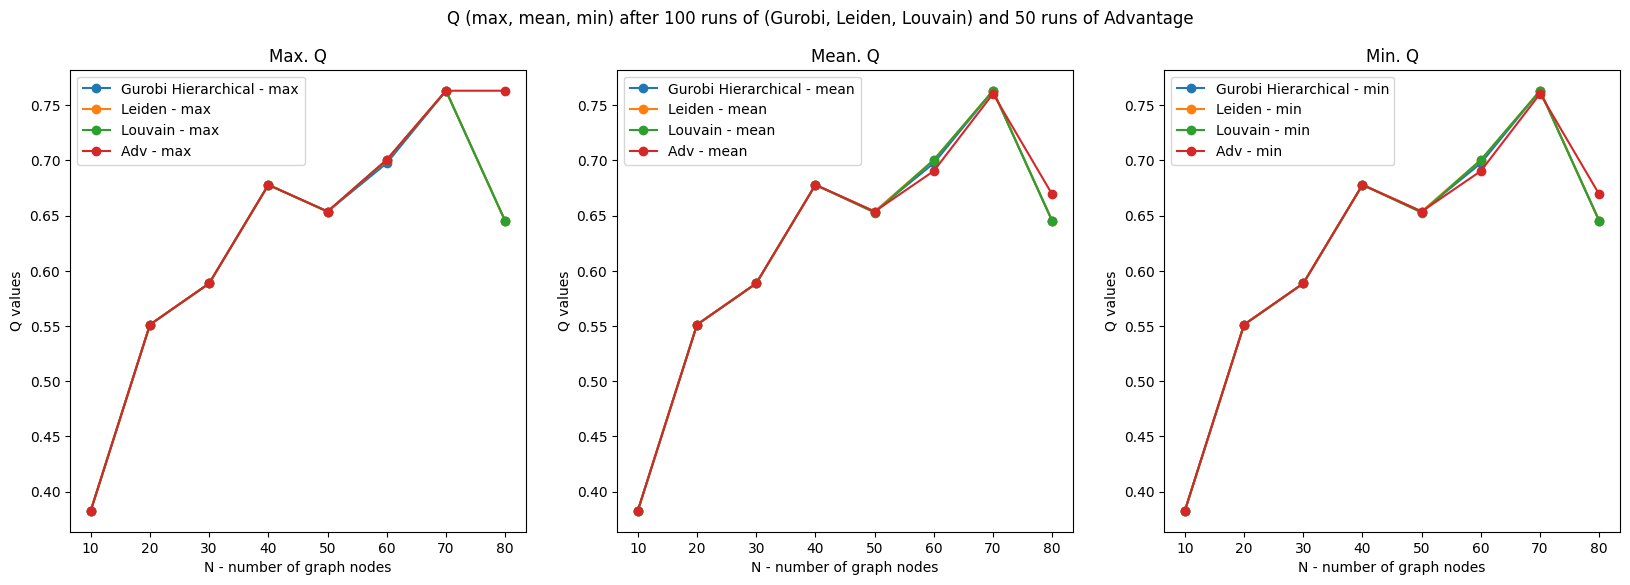

In [37]:
from matplotlib import pyplot as plt


n = 8
num_nodes_up_to_80 = num_nodes[:n]


f, ax = plt.subplots(1, 3, figsize=(20, 6))
f.suptitle("Q (max, mean, min) after 100 runs of (Gurobi, Leiden, Louvain) and 50 runs of Advantage")

# Max
ax[0].plot(num_nodes_up_to_80, mods_gurobi.max(axis=-1)[:n], '-o', label="Gurobi Hierarchical - max")
ax[0].plot(num_nodes_up_to_80, mods_leiden.max(axis=-1)[:n], '-o', label="Leiden - max")
ax[0].plot(num_nodes_up_to_80, mods_louvain.max(axis=-1)[:n], '-o', label="Louvain - max")
ax[0].plot(num_nodes_up_to_80, mods_adv.max(axis=-1), '-o', label="Adv - max")
ax[0].legend()

ax[0].set_title("Max. Q");
ax[0].set_xlabel("N - number of graph nodes");
ax[0].set_ylabel("Q values");

# Mean
ax[1].plot(num_nodes_up_to_80, mods_gurobi.mean(axis=-1)[:n], '-o', label="Gurobi Hierarchical - mean")
ax[1].plot(num_nodes_up_to_80, mods_leiden.mean(axis=-1)[:n], '-o', label="Leiden - mean")
ax[1].plot(num_nodes_up_to_80, mods_louvain.mean(axis=-1)[:n], '-o', label="Louvain - mean")
ax[1].plot(num_nodes_up_to_80, mods_adv.mean(axis=-1), '-o', label="Adv - mean")
ax[1].legend()

ax[1].set_title("Mean. Q");
ax[1].set_xlabel("N - number of graph nodes");
ax[1].set_ylabel("Q values");

# Min
ax[2].plot(num_nodes_up_to_80, mods_gurobi.mean(axis=-1)[:n], '-o', label="Gurobi Hierarchical - min")
ax[2].plot(num_nodes_up_to_80, mods_leiden.mean(axis=-1)[:n], '-o', label="Leiden - min")
ax[2].plot(num_nodes_up_to_80, mods_louvain.mean(axis=-1)[:n], '-o', label="Louvain - min")
ax[2].plot(num_nodes_up_to_80, mods_adv.mean(axis=-1), '-o', label="Adv - min")
ax[2].legend()

ax[2].set_title("Min. Q");
ax[2].set_xlabel("N - number of graph nodes");
ax[2].set_ylabel("Q values");

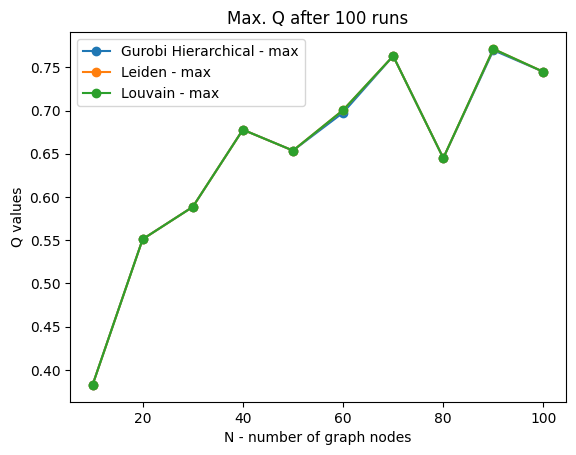

In [17]:
from matplotlib import pyplot as plt


fig, ax = plt.subplots(1)
plt.plot(num_nodes, mods_gurobi.max(axis=-1), '-o', label="Gurobi Hierarchical - max")
plt.plot(num_nodes, mods_leiden.max(axis=-1), '-o', label="Leiden - max")
plt.plot(num_nodes, mods_louvain.max(axis=-1), '-o', label="Louvain - max")
plt.legend()
# ax.set_title(f"Max. Q and mean Q after {N_RUNS} runs");
ax.set_title("Max. Q after 100 runs");
ax.set_xlabel("N - number of graph nodes");
ax.set_ylabel("Q values");